# 7.7. 稠密连接网络（DenseNet）

# 7.7.1. 从ResNet到DenseNet

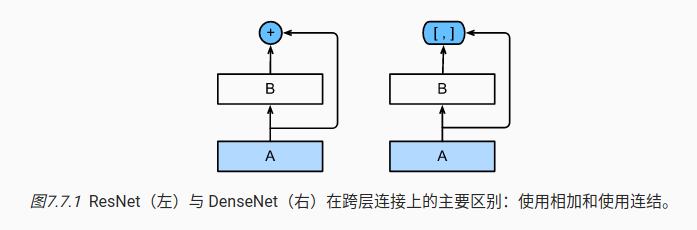

ResNet和DenseNet的关键区别在于，DenseNet输出是连接（用图中的表示）而不是如ResNet的简单相加。 因此，在应用越来越复杂的函数序列后，我们执行从x到其展开式的映射：

# 7.7.2. 稠密块体

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [2]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(
                conv_block(        # 每个块的输出为num_channels, 输入维度逐渐累加
                    num_channels * i + input_channels, num_channels
                )
            )
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

In [3]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

# 7.7.3. 过渡层

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。 而过渡层可以用来控制模型复杂度。 它通过1X1卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [4]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [6]:
# 对上一个例子中稠密块的输出使用通道数为10的过渡层。 此时输出的通道数减为10，高和宽均减半。
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

# 7.7.4. DenseNet模型

1. DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。

2. 接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。 与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。 这里我们设成4，从而与 7.6节的ResNet-18保持一致。 稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

   在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。

3. 与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。

In [7]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
# num_channels为当前的通道数, growth_rate为卷积层通道数（即增长率）, num_convs_in_dense_blocks为每个稠密块使用多少个卷积层
# 每经过一次稠密层，输入维度+growth_rate * num_convs
# 每经过一次过渡层，维度按要求削减
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(
        DenseBlock(num_convs=num_convs, input_channels=num_channels, num_channels=growth_rate)
    )
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [9]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

In [10]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): DenseBlock(
    (net): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# 7.7.5. 训练模型

loss 0.128, train acc 0.952, test acc 0.933
541.8 examples/sec on cuda:0


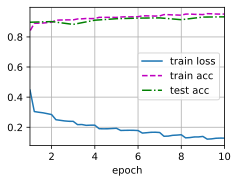

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 8
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 7.7.6. 小结

在跨层连接上，不同于ResNet中将输入与输出相加，稠密连接网络（DenseNet）在通道维上连结输入与输出。

DenseNet的主要构建模块是稠密块和过渡层。

在构建DenseNet时，我们需要通过添加过渡层来控制网络的维数，从而再次减少通道的数量。

# 7.7.7. 练习